<a href="https://colab.research.google.com/github/sunhuanhuan920/ECE1513/blob/main/ECE1513_Assignment_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 3. Data Preparation and Visualization

In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt

**Prepare dataframe for features and labels**

In [3]:
def load_data(filename):

    # Load the dataset
    df = pd.read_csv(filename)

    # Fill missing values with 0
    df = df.fillna(0)

    # Separte labels from dataset
    X = df.drop(columns=['Dataset'])
    y = df['Dataset']
    # Convert labels from 1 for liver patient and 2 for non-liver patient
    # to 0 for non-liver patient and 1 for liver patient
    y = y.map({1: 1, 2: 0})

    # Extract feature names for future use
    feature_names = X.columns.tolist()

    # Convert gender feature to numeric value using a dictionary
    X['Gender'] = X['Gender'].map({'Male': 1, 'Female': 0})

    return X, y

In [5]:
# Dataset file path
dataset_filepath = '/content/drive/MyDrive/Colab Notebooks/ECE1513/indian_liver_patient.csv'

# X：features
# y: labels
X, y = load_data(dataset_filepath)

**Compute and visualize correlation matrix**

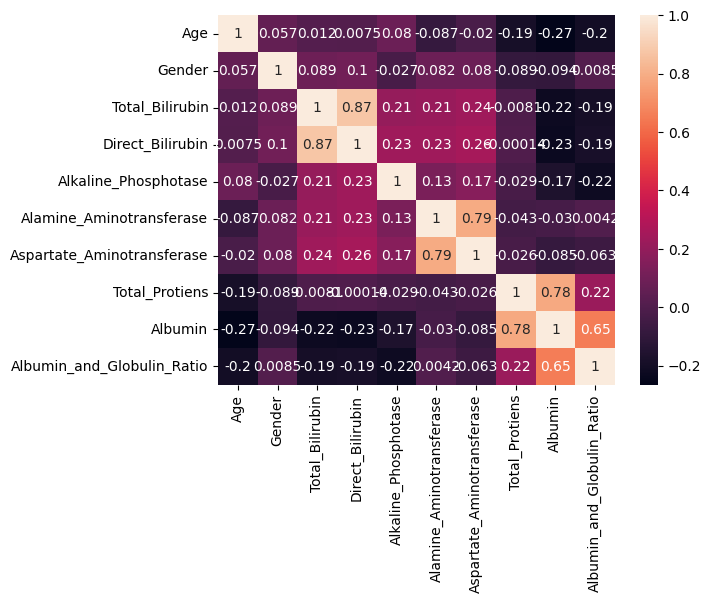

In [6]:
# Compute the correlation matrix
correlation_matrix = X.corr()

sn.heatmap(correlation_matrix, annot=True)
plt.show()

**Determine the two most uncorrelated features**

In [7]:
min_correlated_features = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool)).stack().abs().idxmin()
feature_1, feature_2 = min_correlated_features
correlation_between_min_correlated_features = correlation_matrix.loc[feature_1, feature_2]
print(f"The correlation between {feature_1} and {feature_2} is: {correlation_between_min_correlated_features}")

The correlation between Direct_Bilirubin and Total_Protiens is: -0.00013874142426106262


**Plot data points for the two most uncorrelated features**

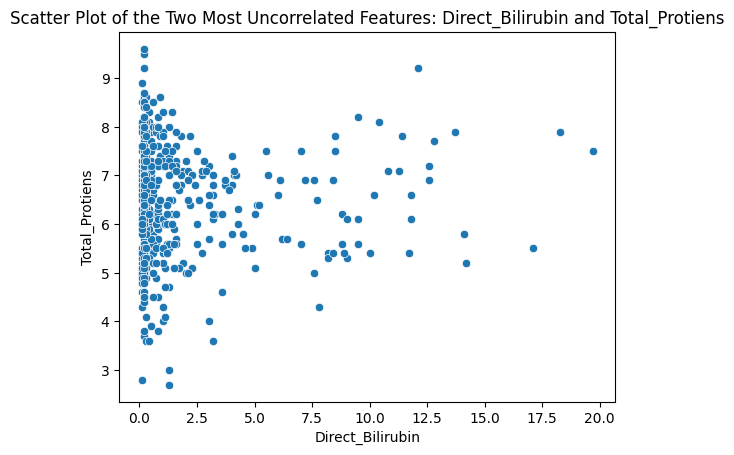

In [8]:
# Scatter plot for the two most uncorrelated features
sn.scatterplot(x=X[feature_1], y=X[feature_2])
plt.xlabel(feature_1)
plt.ylabel(feature_2)
plt.title(f"Scatter Plot of the Two Most Uncorrelated Features: {feature_1} and {feature_2}")
plt.show()

It's difficult to see any distinguishable clusters from the plot above. Thus, I can only assume there is only a single giant cluster within the data points, which does not align with the number of labels, i.e., 2, in the dataset.

# 4. Clustering Methods

**a**

**K-Means Clustering**

It partitions a given dataset into K distinct clusters. The process involves determining K cluster centers and iteratively refining the positions of the cluster centers. In each iteration, data points are reassigned to the cluster whose center is closest, and centers are recomputed based on the data points assigned to each cluster. This process is repeated until the centers no longer move significantly.

Advantages: It's simple to implement and it runs efficiently on large datasets, which gives it the ablity to scale to large datasets.

Disadvantages: The optimal number of cluster is not known in advance. Poor choice of the number of cluster can lead to inferior performance. In addition, it is also sensitive to the intilization of cluster center, as final clusters can vary significatly given different initial cluster centers.

Use cases: It can be used for large and high-dimensional dataset. For example, it can be used to compress image data. By clustering "similar" colors together the replacing them with their representative colors (cluster centers), the number of colors to be used in an image can be reduced.

**Hierarchical Clustering (Agglomerative Clustering)**

Instead of partition data points into clusters, this clustering method seeks to build a hierachy of clusters. The process involves initilizing each data point as a separate cluster and merge them into increasingly larger clusters according to their distance to each other. For example, two clusters that are closest according to the chosen distance metric are merged to form a new cluster. The merging process is repreated, each time considering all the existing clusters and merging the two nearest ones, until all data points from the dataset are merged into a single cluster.

Advantages: It provides a clear and intuitive results in dendrogram, which helps us understand the underlying data structure. In addition, we don't have to specify the number of clusters in advance, which means one less hyperparamter to tune.

Disadvantages: This method can be computationally expensive for large datasets as it requires computing and storing distances between all pairs of clusters/data points. In addition, since the merging steps are irreversible, once two clusters are mergerd, they can not be unmergered. Thus, the effect of suboptimal merging of clusters will propagate, which ultimatly lead to suboptimal result.

Use cases: It can be used for data with hierarchical structures, such as biological taxonomy. The aforementioned cluster merging step can be applied to create taxonomies by grouping biological samples based on the similarity of their characteristics.

**b**

In [9]:
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import accuracy_score, adjusted_rand_score
from sklearn.metrics import silhouette_score

In [19]:
# Number of clusters
num_clusters = 2

# K-Means Clustering
kmeans = KMeans(n_clusters=num_clusters, n_init=10, random_state=21)
kmeans_preds = kmeans.fit_predict(X)

# Agglomerative Clustering
agg_clustering = AgglomerativeClustering(n_clusters=num_clusters)
agg_preds = agg_clustering.fit_predict(X)

K-Means and Agglomerative clustering algorithms assign labels to the data points based on the structure they detect in the data. The labels assigned by clustering algorithms don't have a direct correspondence to the ground truth labels. For example, a clustering algorithm might label two distinct clusters as 0 and 1, but in the ground truth labels, these clusters might be labeled as 1 and 0, respectively. In addition, clustering algorithms might yield more clusters than the number of possible ground truth labels. As a result, using accuracy, e.g., accuracy_score function from sklearn, directly on the predicted cluster labels and the true labels would give misleading results.

In this case, I chose to use a metric called Adjusted Rand Index (ARI) to compare the predicted clusters to the ground truth labels. Specifically, this metric measures the similarity between two data clusterings. For example, it counts pairs of data samples that are assigned in the same or different cluster in the predicted and true clusterings.


1.   If pairs of data points tend to be in the same or different clusters in both clusterings consistently, the ARI will be closer to 1, indicating high similarity.
2.   If pairs of data points are clustered together in one clustering but are clustered in different clusters in the other clustering, the ARI will be closer to 0 or negative, indicating little or no similarity.

In this way, we can compare the predicted clusters to the ground truth labels, regardless of the number of clusters and the specific cluster/label index.


In [15]:
ari_kmeans = adjusted_rand_score(y, kmeans_preds)
ari_agg = adjusted_rand_score(y, agg_preds)

print(f"Adjusted random index for k-means {ari_kmeans}")
print(f"Adjusted random index for agglomerative clustering {ari_agg}")

Adjusted random index for k-means -0.020946915909568455
Adjusted random index for agglomerative clustering -0.004070839846256955


**c**

In [22]:
# Range of possible clusters
possible_clusters = range(2, 11)

# Store the ARI metrics for each number of clusters
kmeans_metrics = []
agg_metrics = []

for n_clusters in possible_clusters:
    # K-Means Clustering
    kmeans = KMeans(n_clusters=n_clusters, n_init=10, random_state=21)
    kmeans_pred = kmeans.fit_predict(X)
    ari_kmeans = adjusted_rand_score(y, kmeans_preds)
    kmeans_metrics.append(ari_kmeans)

    # Agglomerative Clustering
    agg_clustering = AgglomerativeClustering(n_clusters=n_clusters)
    agg_pred = agg_clustering.fit_predict(X)
    ari_agg = adjusted_rand_score(y, agg_preds)
    agg_metrics.append(ari_agg)

best_kmeans_n_clusters = possible_clusters[np.argmax(kmeans_metrics)]
best_agg_n_clusters = possible_clusters[np.argmax(agg_metrics)]

print(f"Best number of clusters for K-Means according to ARI: {best_kmeans_n_clusters}")
print(f"Best number of clusters for Agglomerative Clustering according to ARI: {best_agg_n_clusters}")

Best number of clusters for K-Means according to ARI: 2
Best number of clusters for Agglomerative Clustering according to ARI: 2


**d**

In [31]:
from sklearn.decomposition import PCA

In [33]:
# Number of clusters
num_clusters = 2

# K-Means Clustering
kmeans = KMeans(n_clusters=num_clusters, n_init=10, random_state=21)
kmeans_preds_q4 = kmeans.fit_predict(X)

# Agglomerative Clustering
agg_clustering = AgglomerativeClustering(n_clusters=num_clusters)
agg_preds_q4 = agg_clustering.fit_predict(X)

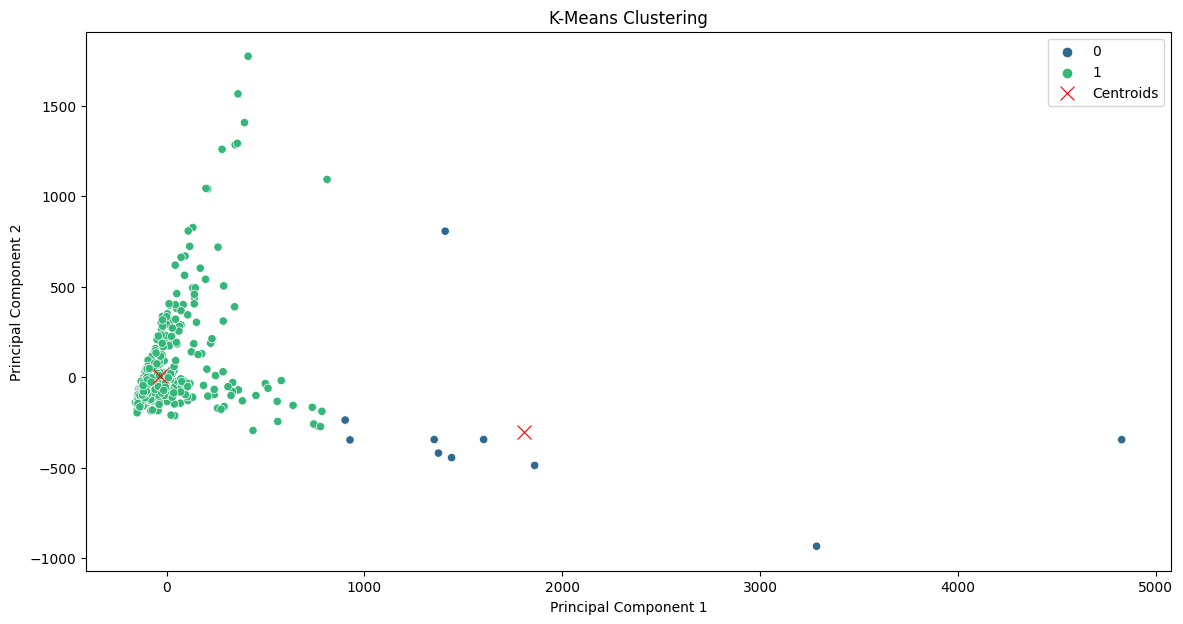

In [42]:
# Reduce the data to two dimensions using PCA for visualization purposes
pca_q4 = PCA(n_components=2)
X_reduced = pca_q4.fit_transform(X.to_numpy())

# Plotting the results of K-Means Clustering
plt.figure(figsize=(14, 7))

# Seaborn scatter plot for K-Means
sn.scatterplot(x=X_reduced[:, 0], y=X_reduced[:, 1], hue=kmeans_preds, palette='viridis', marker='o', legend='full')
centers = pca_q4.transform(kmeans.cluster_centers_)
sn.scatterplot(x=centers[:, 0], y=centers[:, 1], s=100, color='red', marker='x', label='Centroids')
plt.title('K-Means Clustering')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

plt.show()

The best number of cluster for both clustering algorithm is 2, which is exactly the number of labels we have for the dataset.

From the plot above, it's not visually clear whether there are other subgroups of data within the data points that are in the same cluster.

# 5. Dimensionality Reduction

**a**

**Principal Component Analysis**

It identifies the directions, called principal compoenents, along which the variance in the data is maximized. As a result, the original data can be projected to a new coordinate system where most of the variation in the data can be maintained and described using fewer dimensions.

Advantages: It can reduce the dimensionality of the data, which helps in overcoming issues from the curse of dimensionality in many machine learning algorithms. In addition, by keeping only the principal components, it highlights the most important features and relationships present in the data and can help in noise reduction.

Disadvantages: While reducing dimensions, loss of information is inevitable. It is also sensitive to scaling and outliers, as they might affect the direction along which the data variance is maximized. In addition, the resulting principal components may not as interpretable as the original features.

Use cases: It can be used for visualizing the structure of high-dimensional data in two or three dimensions. It is also a useful preprocessing technique that allows some machine learning algorithms converge faster.

**t-Distributed Stochastic Neighbor Embedding**

It is a non-linear dimensionality reduction technique. It models a joint probability distribution to measure similarities between data points in the high-dimensional space, it then defines a similar distribution in the low-dimensional space and tries to minimize the KL divergence between these two distributions.

Advantages: It is very effective for visualizing high-dimensional data and reveal the data structure at different scales. In addition, it can also caputre non-linear relationships between data points.

Disadvantages: This method is computationally expensive for large dataset. Different runs of this algorithm on a same dataset may yield different result due to its stochastic nature.

Use cases: It is widely employed for visualizing the structure of high-dimensional data in two or three dimensions.

**b & c**

In [23]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

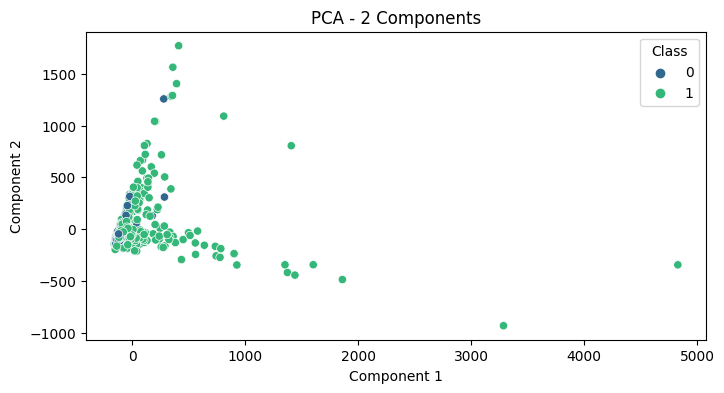

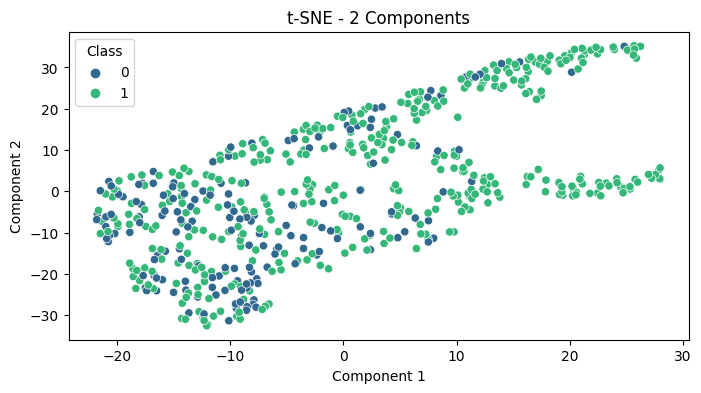

In [30]:
# PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# t-SNE
tsne = TSNE(n_components=2, random_state=21)
X_tsne = tsne.fit_transform(X)

# PCA Plot
plt.figure(figsize=(8, 4))
sn.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y, palette="viridis")
plt.title('PCA - 2 Components')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.legend(title='Class')
plt.show()

# t-SNE Plot
plt.figure(figsize=(8, 4))
sn.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=y, palette="viridis")
plt.title('t-SNE - 2 Components')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.legend(title='Class')
plt.show()

**d**

Visually speaking, t-SNE appears more effective than PCA in reducing the data while preserving the categorization. This effectiveness comes from t-SNE's ability to capture non-linear structures in data, which PCA, a linear transformation method, may not capture. While PCA projects data onto axes that maximize variance and maintain global structure, t-SNE focuses on preserving local neighborhoods and relationships between data points.